In [17]:
import os
import joblib
import matplotlib.pyplot as plt
from keras.applications import VGG16
from modules.helpers import random_image
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


ImportError: cannot import name 'encode_image' from 'modules.helpers' (c:\Users\hadii\Desktop\Projects\MLOps\Multiclass_Image_Classification_and_MLOps\modules\helpers.py)

In [2]:
train_dir = 'data\seg_train\seg_train'
test_dir = 'data\seg_test\seg_test'
pred_dir = 'data\seg_pred\seg_pred'

**Explore the data**

In [3]:
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f'There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}')
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f'There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}')
for dirpath, dirnames, filenames in os.walk(pred_dir):
  print(f'There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}')

There are 6 directories and 0 files in data\seg_train\seg_train
There are 0 directories and 2191 files in data\seg_train\seg_train\buildings
There are 0 directories and 2271 files in data\seg_train\seg_train\forest
There are 0 directories and 2404 files in data\seg_train\seg_train\glacier
There are 0 directories and 2512 files in data\seg_train\seg_train\mountain
There are 0 directories and 2274 files in data\seg_train\seg_train\sea
There are 0 directories and 2382 files in data\seg_train\seg_train\street
There are 6 directories and 0 files in data\seg_test\seg_test
There are 0 directories and 437 files in data\seg_test\seg_test\buildings
There are 0 directories and 474 files in data\seg_test\seg_test\forest
There are 0 directories and 553 files in data\seg_test\seg_test\glacier
There are 0 directories and 525 files in data\seg_test\seg_test\mountain
There are 0 directories and 510 files in data\seg_test\seg_test\sea
There are 0 directories and 501 files in data\seg_test\seg_test\stree

In [4]:
image_categories = os.listdir(train_dir)
print(image_categories)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Image shape: (150, 150, 3)


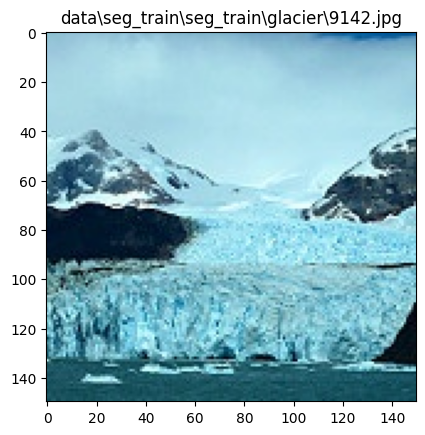

In [5]:
img = random_image(train_dir)

In [6]:
# Creates an ImageDataGenerator object to augment the training data
generate_train_data = ImageDataGenerator(rotation_range=0,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            brightness_range=(0.8, 1.2),
                            shear_range=0.2,
                            zoom_range=0.2,
                            rescale = 1/255, 
                            horizontal_flip=True,
                            vertical_flip=False)

# Returns an iterator with batches of 32 images
train_data = generate_train_data.flow_from_directory(
                                    train_dir,
                                    target_size=(150, 150),
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=32,
                                    shuffle=True,
                                    # save_to_dir=None,
                                    # save_prefix='',
                                    # save_format='png',
                                    subset='training')

Found 14034 images belonging to 6 classes.


**View the structure of the augmented train data**

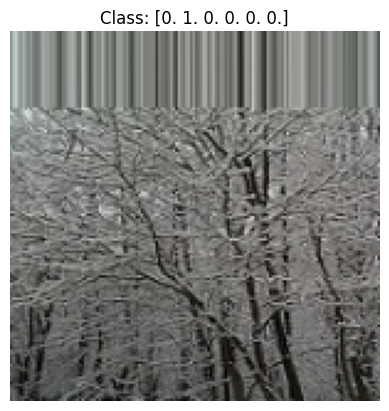

In [7]:
# Train_data is an iterator, so we fetch the first set of items
image_batch, label_batch = next(train_data)
image = image_batch[0]
label = label_batch[0]
image_shape = image.shape

plt.imshow(image)
plt.title('Class: {}'.format(label))  # Labels are one hot encoded between the 6 categories
plt.axis('off')
plt.show()

In [8]:
# Repeat the process for test data
generate_test_data = ImageDataGenerator(
                                rescale=1/255)

test_data = generate_test_data.flow_from_directory(
                                    test_dir,
                                    target_size=(150, 150),
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=32,
                                    shuffle=True)
                                    # save_to_dir=None,
                                    # save_prefix='',
                                    # save_format='png',

Found 3000 images belonging to 6 classes.


**Creating the CNN Architecture**

In [9]:
# Creating the CNN Architecture manually
model = Sequential()

# The model seemed to learn better when using 32, 64, 128 filters in the Convolution Layers
# rather than the initial idea of 16, 32, 64
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape)) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

# I stuck with 2 Dense layers, each with 128 neurons, as I felt this would be more suitable
# for a medium-sized training dataset (14000 images) such as the one used to train the model
# A dropout rate of 0.25 keeps the model from becoming too reliant on certain neurons
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# Outputs probabilities for the 6 output classes
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\hadii\Desktop\Projects\MLOps\Multiclass_Image_Classification_and_MLOps\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,845,638 (18.48 MB)

 Trainable params: 4,845,638 (18.48 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
 
history = model.fit(train_data,
                    batch_size=16, # a batch size of 16 seemed more effective than 32 here
                    epochs=30,
                    verbose=1,
                    callbacks=[early_stopping],
                    shuffle=True,
                    steps_per_epoch=(train_data.samples// train_data.batch_size),
                    validation_data=test_data,
                    validation_steps=(test_data.samples// test_data.batch_size))

Epoch 1/30


c:\Users\hadii\Desktop\Projects\MLOps\Multiclass_Image_Classification_and_MLOps\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 232s 520ms/step - accuracy: 0.4493 - loss: 1.3336 - val_accuracy: 0.6462 - val_loss: 0.9282
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - accuracy: 0.6875 - loss: 0.9281 - val_accuracy: 0.5833 - val_loss: 0.9785
Epoch 3/30


C:\Users\hadii\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


438/438 ━━━━━━━━━━━━━━━━━━━━ 148s 336ms/step - accuracy: 0.6374 - loss: 0.9486 - val_accuracy: 0.7604 - val_loss: 0.6558
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step - accuracy: 0.7188 - loss: 0.8942 - val_accuracy: 0.7917 - val_loss: 0.6450
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 184s 416ms/step - accuracy: 0.7226 - loss: 0.7544 - val_accuracy: 0.7776 - val_loss: 0.6325
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step - accuracy: 0.5938 - loss: 1.0678 - val_accuracy: 0.8750 - val_loss: 0.5315
Epoch 7/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 162s 367ms/step - accuracy: 0.7416 - loss: 0.7071 - val_accuracy: 0.8310 - val_loss: 0.4739
Epoch 8/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - accuracy: 0.9375 - loss: 0.3018 - val_accuracy: 0.7917 - val_loss: 0.5447
Epoch 9/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 180s 407ms/step - accuracy: 0.7749 - loss: 0.6218 - val_accuracy: 0.8246 - val_loss: 0.4912
Epoch 10/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - accuracy: 0.8125 - loss: 0.5556 - va

In [14]:
model.evaluate(test_data)

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.8408 - loss: 0.4532


[0.455363005399704, 0.8393333554267883]

In [15]:
joblib.dump(model, 'manual_cnn_model.joblib')

['manual_cnn_model.joblib']

**Using a pretrained model for comparison**

In [14]:
# pre-trained model with 16 layers that have predefined weights, can also use VGG19
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Keeps the weights of the pretrained layers from being altered
for layer in vgg_base.layers:
    layer.trainable = False

In [15]:
vgg_model = Sequential()

vgg_model.add(vgg_base)

vgg_model.add(Flatten())

# Attempted to try a newer approach to see which model works better.
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(6, activation='softmax'))

vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
 
history_with_vgg = vgg_model.fit(  train_data,
                                   batch_size=16,
                                   epochs=30,
                                   verbose=1,
                                   callbacks=[early_stopping],
                                   shuffle=True,
                                   steps_per_epoch=(train_data.samples// train_data.batch_size),
                                   validation_data=test_data,
                                   validation_steps=(test_data.samples// test_data.batch_size))

Epoch 1/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1044s 2s/step - accuracy: 0.6767 - loss: 0.8677 - val_accuracy: 0.8229 - val_loss: 0.4276
Epoch 2/30
  1/438 ━━━━━━━━━━━━━━━━━━━━ 14:10 2s/step - accuracy: 0.7188 - loss: 0.5909

C:\Users\hadii\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7188 - loss: 0.5909 - val_accuracy: 0.7500 - val_loss: 0.4804
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1113s 3s/step - accuracy: 0.7837 - loss: 0.5621 - val_accuracy: 0.8679 - val_loss: 0.3511
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8438 - loss: 0.4824 - val_accuracy: 0.9583 - val_loss: 0.1506
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1144s 3s/step - accuracy: 0.8192 - loss: 0.5142 - val_accuracy: 0.8619 - val_loss: 0.3547
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8125 - loss: 0.4622 - val_accuracy: 0.7917 - val_loss: 0.4192
Epoch 7/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1200s 3s/step - accuracy: 0.8067 - loss: 0.5081 - val_accuracy: 0.8602 - val_loss: 0.3645
Epoch 8/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8125 - loss: 0.4456 - val_accuracy: 0.8750 - val_loss: 0.5011
Epoch 9/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1183s 3s/step - accuracy: 0.8116 - loss: 0.4962 - val_accuracy: 0.875

In [17]:
# The model built on top of vgg yeilds better accuracy and lower loss, so we will use this
vgg_model.evaluate(test_data)

94/94 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8660 - loss: 0.3640


[0.3488072454929352, 0.8703333139419556]

In [18]:
joblib.dump(vgg_model, 'vgg_model.joblib')

['vgg_model.joblib']